In [1]:
import os
import math
import pickle
import tqdm
from multiprocessing import Pool

import numpy as np
import pandas as pd
import cvxpy as cp
import torch
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from src.mSSRM_PGA import mSSRM_PGA
from src.utils import preprocess_backtest_data, preprocess_backtest_data_rolling_univ
from src.backtest import aggregate_weights, backtest, backtest_baseline

device = torch.device('cuda:4')

In [2]:
sns.set()

In [3]:
backtest_start = '2019-11'
backtest_end = '2025-06'
trading_cost = 0.004
lagging = 2
window_size = 21

In [4]:
universes = ['universe1', 'universe2', 'universe3', 'universe4', 'universe5', 'universe6', 'universe7', 'universe8']
ports = ['MaxSharpe', 'MaxSortino']
models = ['Mamba', 'TRF', 'LSTM']
optimizers = ['sophia']

In [5]:
universe1_backtest_yearmons, universe1_backtest_data, universe1_missing_mask = preprocess_backtest_data(f'data/universe1.csv', device)
universe2_backtest_yearmons, universe2_backtest_data, universe2_missing_mask = preprocess_backtest_data(f'data/universe2.csv', device)
universe3_backtest_yearmons, universe3_backtest_data, universe3_missing_mask = preprocess_backtest_data(f'data/universe3.csv', device)
universe4_backtest_yearmons, universe4_backtest_data, universe4_missing_mask = preprocess_backtest_data(f'data/universe4.csv', device)
universe5_backtest_yearmons, universe5_backtest_data, universe5_missing_mask = preprocess_backtest_data(f'data/universe5.csv', device)
universe6_backtest_yearmons, universe6_backtest_data, universe6_missing_mask = preprocess_backtest_data(f'data/universe6.csv', device)
universe7_backtest_yearmons, universe7_backtest_data, universe7_missing_mask = preprocess_backtest_data_rolling_univ(f'data/universe7.csv', device)
universe8_backtest_yearmons, universe8_backtest_data, universe8_missing_mask = preprocess_backtest_data_rolling_univ(f'data/universe8.csv', device)

In [6]:
directory = 'result/'
for universe in universes:
    for port in ports:
        file_name = universe + '_weights_' + port.lower()
        if os.path.exists(directory + file_name + '.pkl'):
            with open(directory + file_name + '.pkl', 'rb') as f:
                object = pickle.load(f)
            exec(file_name + ' = object')
        else:
            print(file_name)

In [7]:
directory = 'result/'
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                file_name = f'{universe}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                if os.path.exists(directory + file_name + '.pkl'):
                    with open(directory + file_name + '.pkl', 'rb') as f:
                        object = pickle.load(f)
                    exec(file_name + ' = object')
                else:
                    print(file_name)

In [8]:
directory = 'result/'
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                file_name = f'{universe}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_logits'
                if os.path.exists(directory + file_name + '.pkl'):
                    with open(directory + file_name + '.pkl', 'rb') as f:
                        object = pickle.load(f)
                    exec(file_name + ' = object')
                else:
                    print(file_name)

In [9]:
directory = 'result/'
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                file_name = f'{universe}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                if os.path.exists(directory + file_name + '.pkl'):
                    with open(directory + file_name + '.pkl', 'rb') as f:
                        object = pickle.load(f)
                    exec(file_name + ' = object')
                else:
                    print(file_name)

In [10]:
directory = 'result/'
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                file_name = f'{universe}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                if os.path.exists(directory + file_name + '.pkl'):
                    with open(directory + file_name + '.pkl', 'rb') as f:
                        object = pickle.load(f)
                    exec(file_name + ' = object')
                else:
                    print(file_name)

In [11]:
universe = 'universe1'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe1_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe1_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:10<00:00, 38.02it/s]


<Axes: >

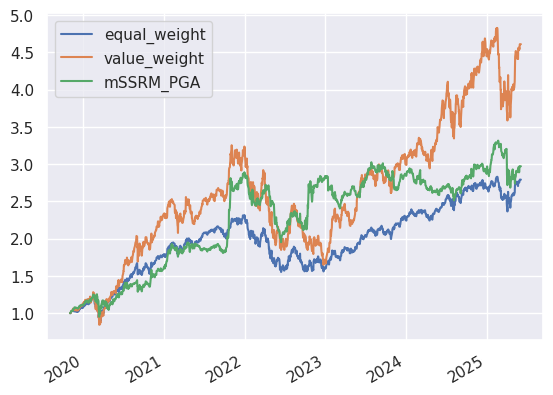

In [12]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [13]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    2.791154
value_weight    4.609993
mSSRM_PGA       2.970512
Name: 2025-06-04 00:00:00, dtype: float64

In [14]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe1_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.783920
value_weight    0.794383
mSSRM_PGA       0.768097
dtype: float64

In [15]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe1_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    1.218829
value_weight    1.256767
mSSRM_PGA       1.247057
dtype: float64

In [16]:
universe = 'universe2'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe2_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe2_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:28<00:00, 10.39it/s]


<Axes: >

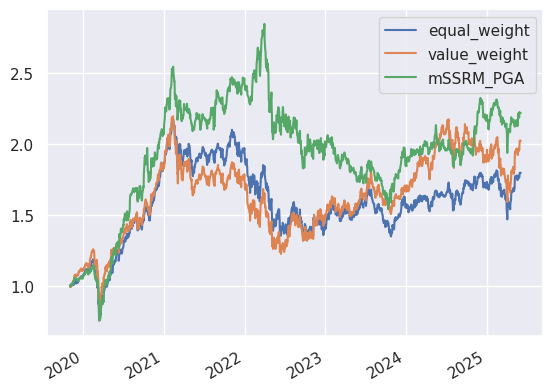

In [17]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [18]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    1.796885
value_weight    2.024329
mSSRM_PGA       2.219525
Name: 2025-06-04 00:00:00, dtype: float64

In [19]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe2_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.415025
value_weight    0.432001
mSSRM_PGA       0.561618
dtype: float64

In [20]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe2_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.645726
value_weight    0.681724
mSSRM_PGA       0.863642
dtype: float64

In [21]:
universe = 'universe3'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe3_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe3_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 689/689 [00:04<00:00, 160.16it/s]


<Axes: >

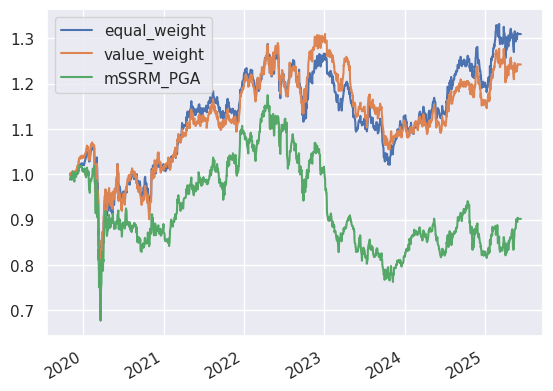

In [22]:
universe3_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [23]:
universe3_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    1.309171
value_weight    1.242084
mSSRM_PGA       0.901344
Name: 2025-06-13 00:00:00, dtype: float64

In [24]:
universe3_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe3_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.285984
value_weight    0.230851
mSSRM_PGA      -0.097929
dtype: float64

In [25]:
universe3_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe3_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.428579
value_weight    0.352448
mSSRM_PGA      -0.145047
dtype: float64

In [26]:
universe = 'universe4'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe4_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe4_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 689/689 [00:07<00:00, 91.58it/s]


<Axes: >

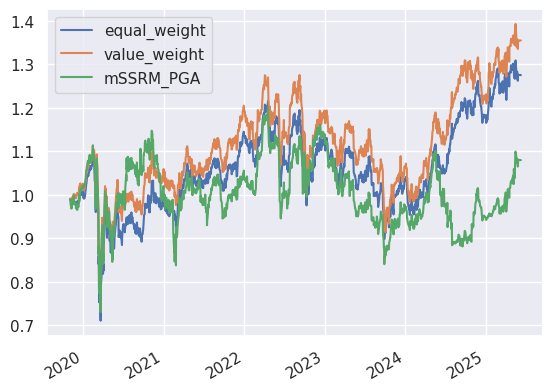

In [27]:
universe4_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [28]:
universe4_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    1.275059
value_weight    1.354596
mSSRM_PGA       1.079537
Name: 2025-06-09 00:00:00, dtype: float64

In [29]:
universe4_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe4_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.200605
value_weight    0.247113
mSSRM_PGA       0.055868
dtype: float64

In [30]:
universe4_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe4_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.305515
value_weight    0.379062
mSSRM_PGA       0.086786
dtype: float64

In [31]:
universe = 'universe5'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe5_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe5_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 689/689 [00:13<00:00, 51.47it/s]


<Axes: >

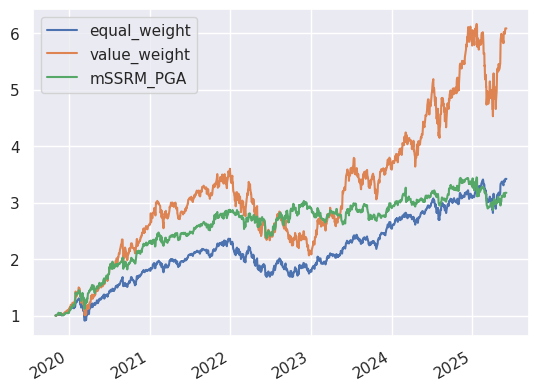

In [32]:
universe5_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [33]:
universe5_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    3.418608
value_weight    6.082219
mSSRM_PGA       3.172596
Name: 2025-06-04 00:00:00, dtype: float64

In [34]:
universe5_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe5_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.869313
value_weight    0.940606
mSSRM_PGA       0.879867
dtype: float64

In [35]:
universe5_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe5_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    1.369136
value_weight    1.501136
mSSRM_PGA       1.400578
dtype: float64

In [36]:
universe = 'universe6'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe6_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe6_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 689/689 [00:12<00:00, 54.67it/s]


<Axes: >

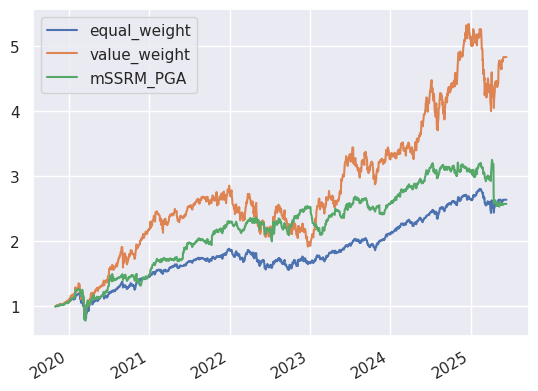

In [37]:
universe6_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [38]:
universe6_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    2.639756
value_weight    4.833471
mSSRM_PGA       2.576248
Name: 2025-06-13 00:00:00, dtype: float64

In [39]:
universe6_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe6_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.906092
value_weight    0.913808
mSSRM_PGA       0.674125
dtype: float64

In [40]:
universe6_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe6_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    1.373078
value_weight    1.440613
mSSRM_PGA       0.961901
dtype: float64

In [41]:
universe = 'universe7'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe7_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe7_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [01:13<00:00,  3.99it/s]


<Axes: >

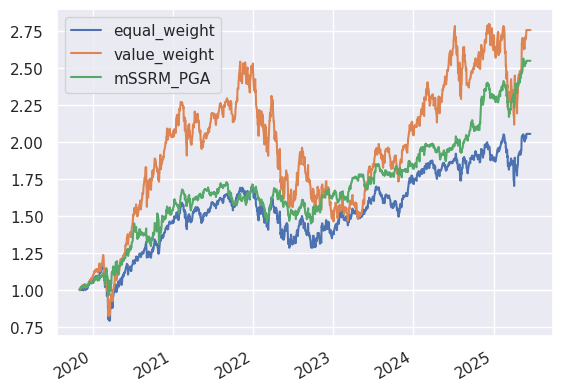

In [42]:
universe7_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [43]:
universe7_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    2.053930
value_weight    2.756242
mSSRM_PGA       2.548474
Name: 2025-06-17 00:00:00, dtype: float64

In [44]:
universe7_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe7_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.548826
value_weight    0.583089
mSSRM_PGA       0.822062
dtype: float64

In [45]:
universe7_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe7_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.852393
value_weight    0.909654
mSSRM_PGA       1.301004
dtype: float64

In [46]:
universe = 'universe8'
yearmons = eval(f'{universe}_backtest_yearmons')
data = eval(f'{universe}_backtest_data')
missing_mask = eval(f'{universe}_missing_mask')

universe8_baseline_backtest = backtest_baseline(yearmons, data, missing_mask, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(0.0, index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon, ~missing_mask[yearmon].cpu().numpy()].iloc[-21:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon, ~missing_mask[yearmon].cpu().numpy()] = mSSRM_PGA(m = matR.shape[1], iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe8_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, missing_mask, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 424/424 [02:08<00:00,  3.31it/s]


<Axes: >

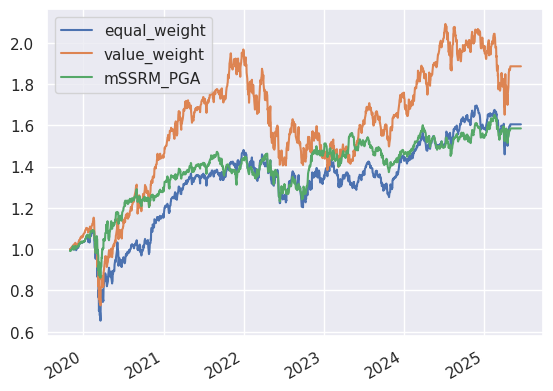

In [47]:
universe8_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [48]:
universe8_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    1.604880
value_weight    1.886134
mSSRM_PGA       1.585038
Name: 2025-06-17 00:00:00, dtype: float64

In [49]:
universe8_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe8_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.394266
value_weight    0.455819
mSSRM_PGA       0.528062
dtype: float64

In [50]:
universe8_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe8_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.584341
value_weight    0.687644
mSSRM_PGA       0.801730
dtype: float64

In [51]:
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                try:
                    object_name = f'{universe}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                    target_name = f'{universe}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
                    exec(f'{target_name} = pd.concat([backtest({universe}_backtest_yearmons, {universe}_backtest_data, {universe}_missing_mask, x, backtest_start, trading_cost, lagging) for x in {object_name}], axis = 1).mean(1)')
                except:
                    print(target_name)
                    continue

In [52]:
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                try:
                    object_name = f'{universe}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                    target_name = f'{universe}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
                    exec(f'{target_name} = pd.concat([backtest({universe}_backtest_yearmons, {universe}_backtest_data, {universe}_missing_mask, x, backtest_start, trading_cost, lagging) for x in {object_name}], axis = 1).mean(1)')
                except:
                    print(target_name)
                    continue

In [53]:
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                if True:
                    object_name = f'{universe}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_all_weights'
                    target_name = f'{universe}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
                    exec(f'weights = aggregate_weights({universe}_backtest_yearmons, {universe}_backtest_data, {object_name}, backtest_start)')
                    exec(f'{target_name} = backtest({universe}_backtest_yearmons, {universe}_backtest_data, {universe}_missing_mask, weights, backtest_start, trading_cost, lagging)')
                else:
                    print(target_name)
                    continue

In [54]:
colors = ['red', 'blue', 'green']

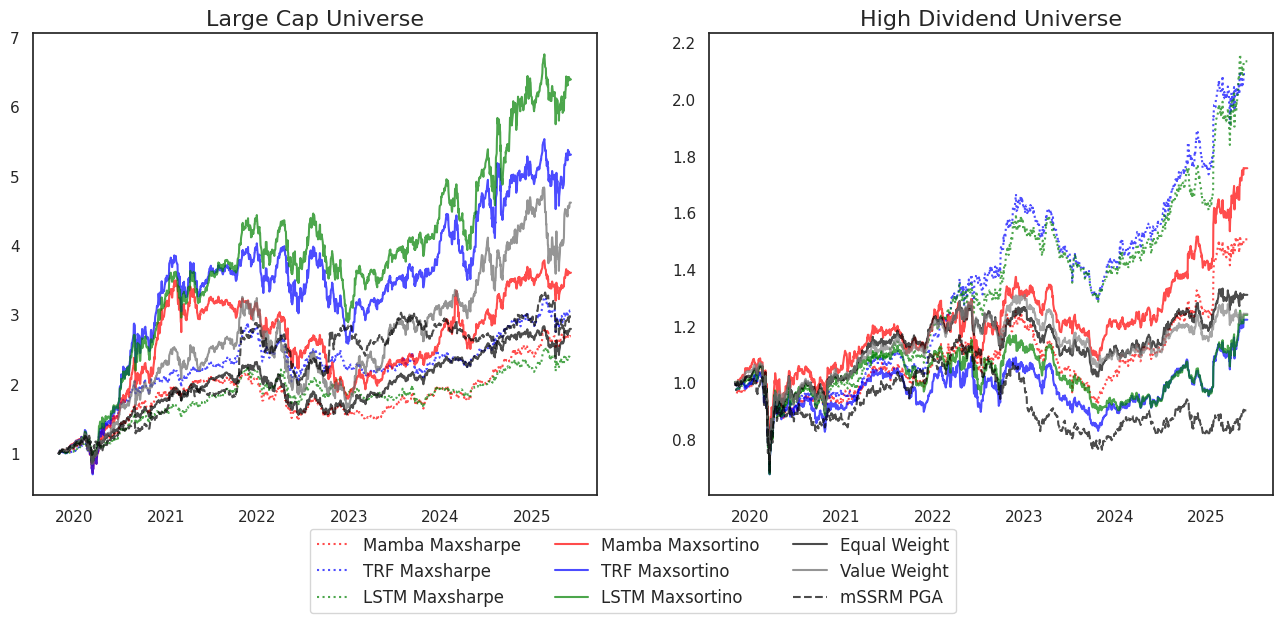

In [55]:
sns.set_style(style='white')

colormap = mpl.colormaps['tab10']
alpha = 0.7

fig = plt.figure(figsize = (16, 6))

ax = plt.subplot(1, 2, 1)

universe = 'Universe1'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('Large Cap Universe', fontsize = 16)


fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

ax = plt.subplot(1, 2, 2)


universe = 'Universe3'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('High Dividend Universe', fontsize = 16)

plt.show()

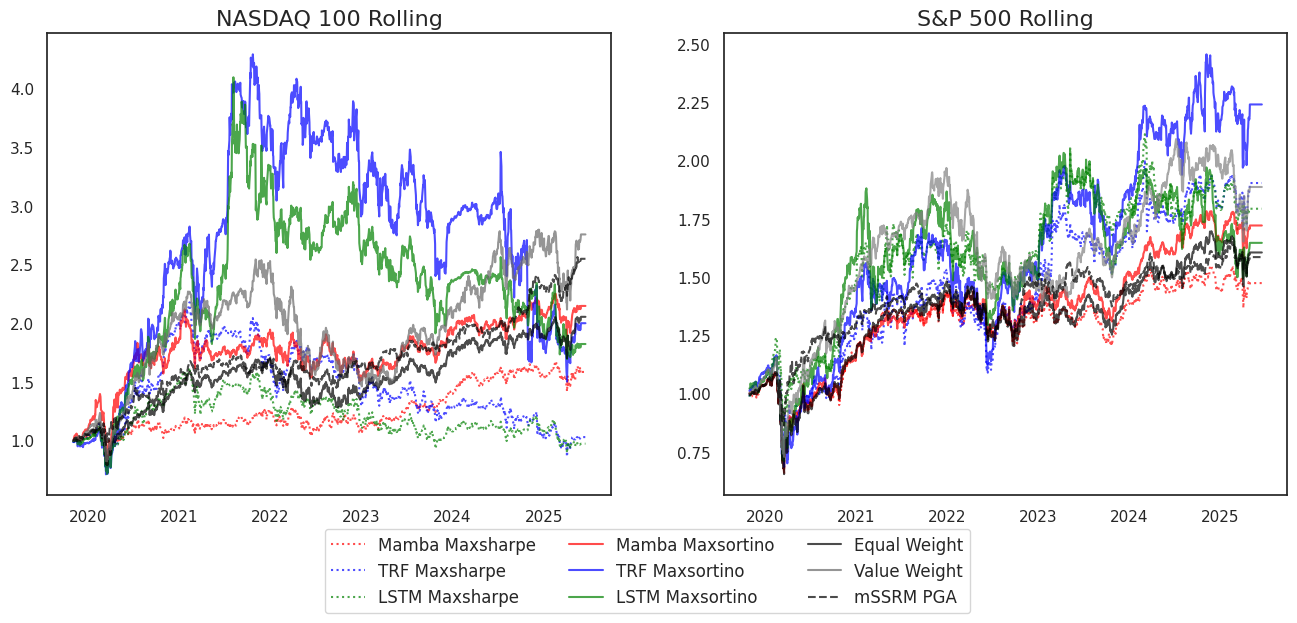

In [56]:
sns.set_style(style='white')

colormap = mpl.colormaps['tab10']
alpha = 0.7

fig = plt.figure(figsize = (16, 6))

ax = plt.subplot(1, 2, 1)

universe = 'Universe7'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('NASDAQ 100 Rolling', fontsize = 16)


fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

ax = plt.subplot(1, 2, 2)


universe = 'Universe8'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('S&P 500 Rolling', fontsize = 16)

plt.show()

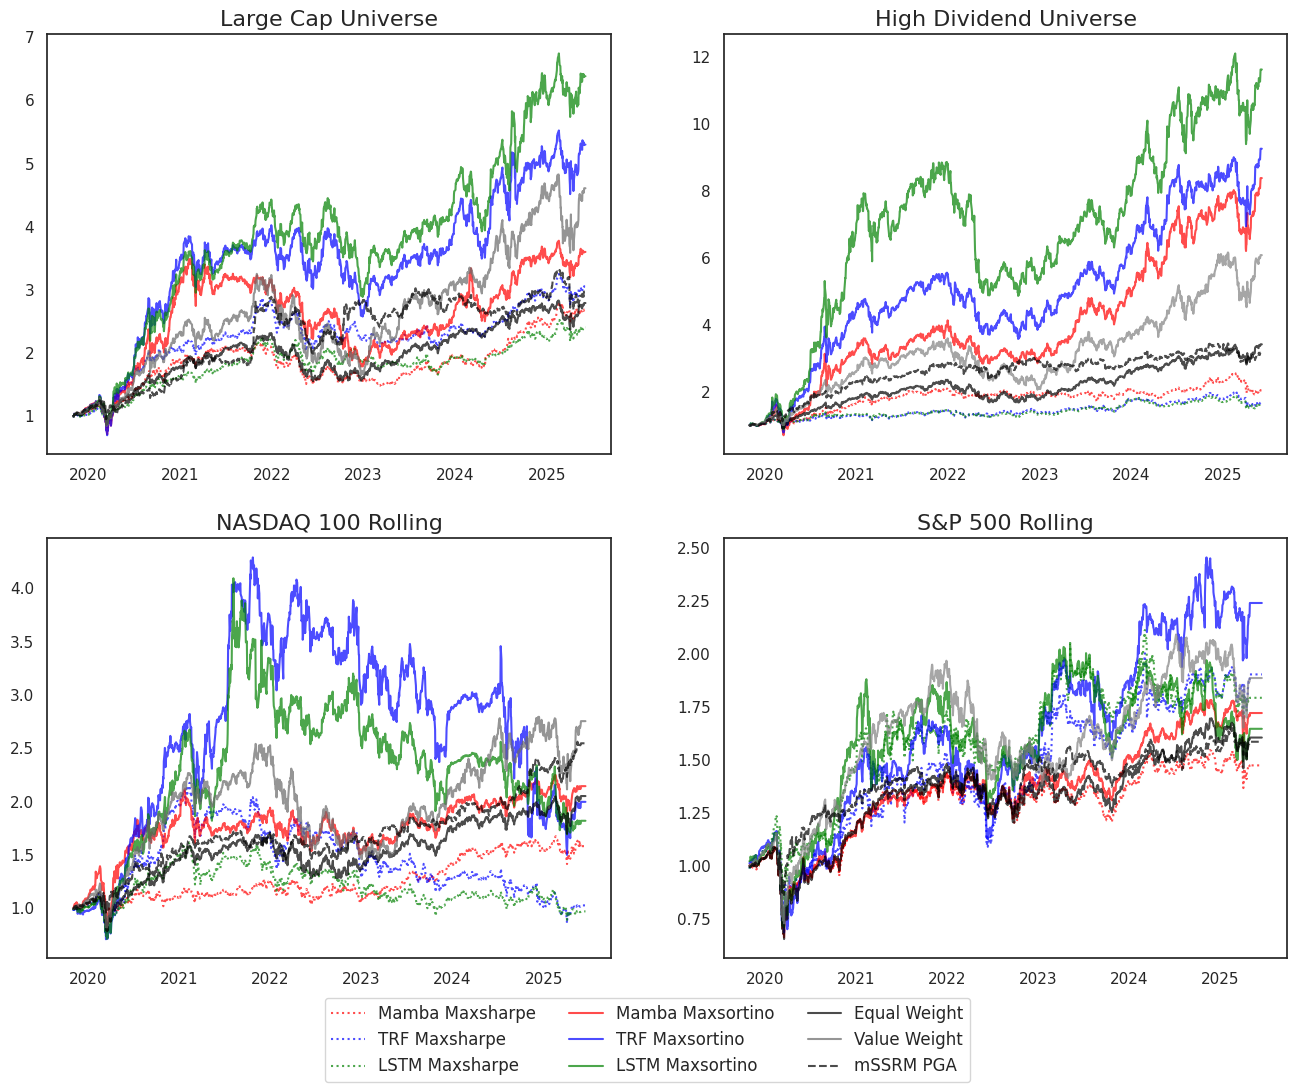

In [57]:
sns.set_style(style='white')

colormap = mpl.colormaps['tab10']
alpha = 0.7

fig = plt.figure(figsize = (16, 12))

ax = plt.subplot(2, 2, 1)

universe = 'Universe1'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('Large Cap Universe', fontsize = 16)


fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.0), ncol=3, fontsize=12)

ax = plt.subplot(2, 2, 2)


universe = 'Universe5'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('High Dividend Universe', fontsize = 16)

ax = plt.subplot(2, 2, 3)

universe = 'Universe7'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('NASDAQ 100 Rolling', fontsize = 16)

ax = plt.subplot(2, 2, 4)


universe = 'Universe8'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('S&P 500 Rolling', fontsize = 16)

plt.show()

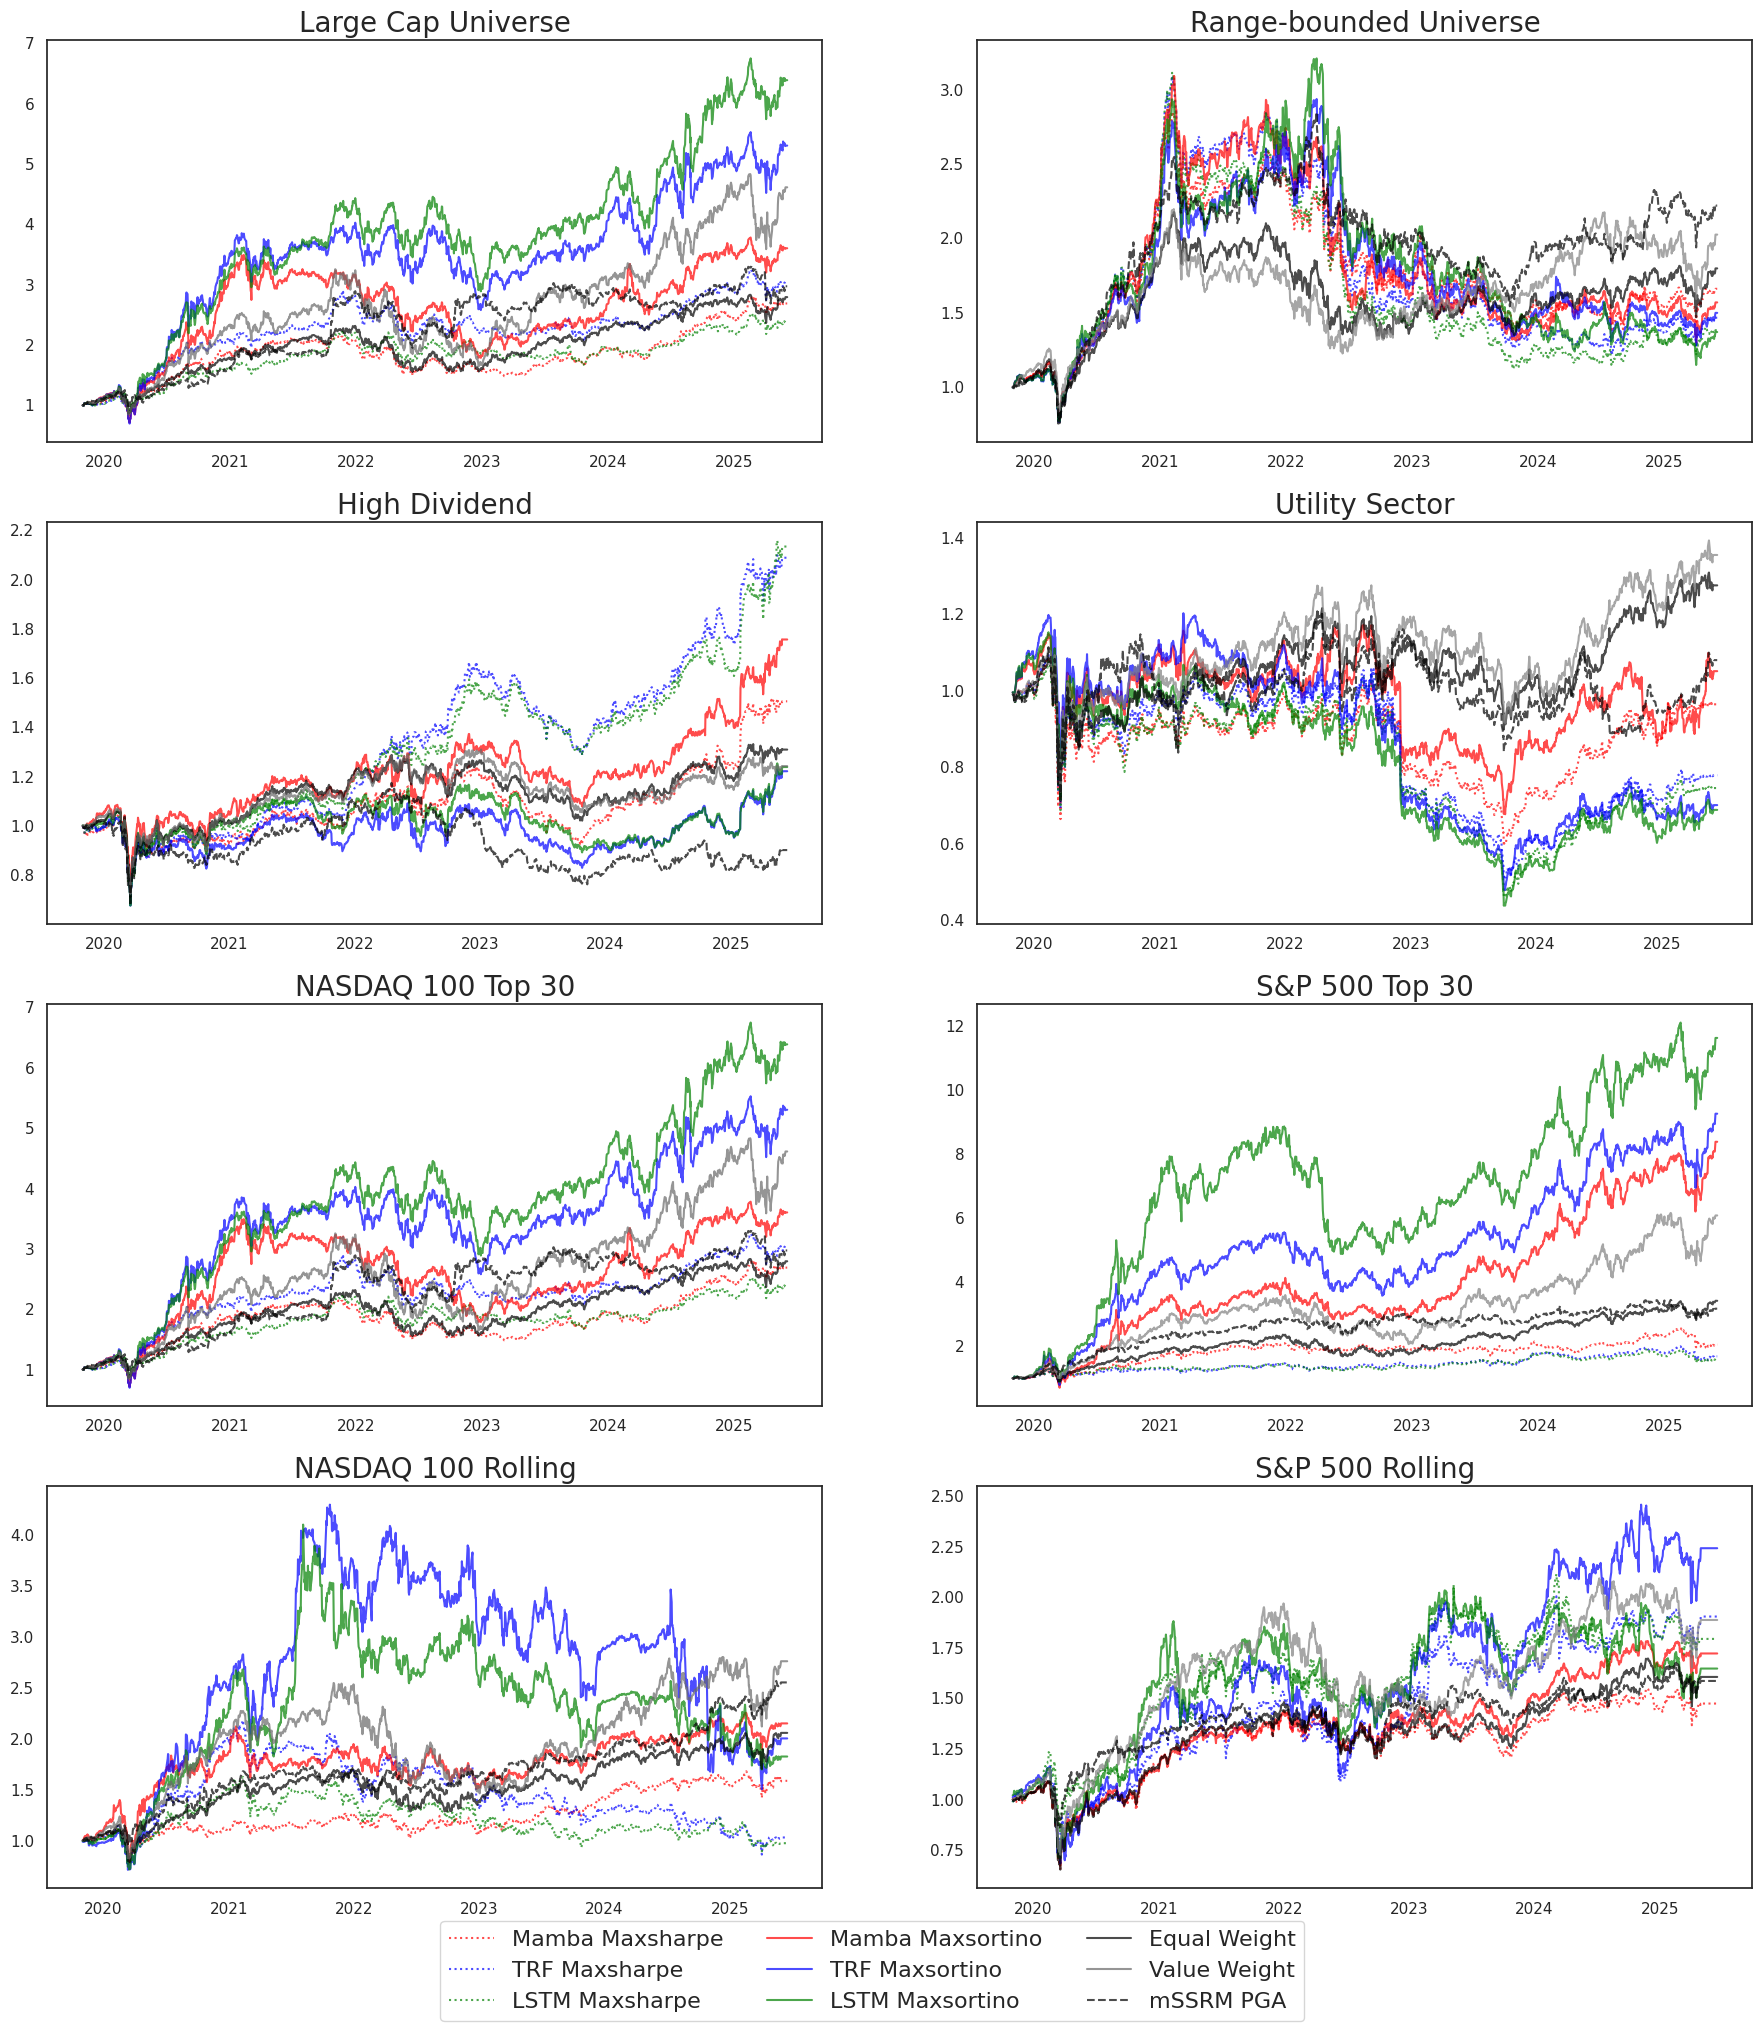

In [86]:
sns.set_style(style='white')

colormap = mpl.colormaps['tab10']
alpha = 0.7

fig = plt.figure(figsize = (22, 24))

ax = plt.subplot(4, 2, 1)

universe = 'Universe1'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('Large Cap Universe', fontsize = 20)


fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=16)

ax = plt.subplot(4, 2, 2)


universe = 'Universe2'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('Range-bounded Universe', fontsize = 20)

ax = plt.subplot(4, 2, 3)

universe = 'Universe3'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('High Dividend', fontsize = 20)

ax = plt.subplot(4, 2, 4)


universe = 'Universe4'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('Utility Sector', fontsize = 20)


ax = plt.subplot(4, 2, 5)

universe = 'Universe1'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('NASDAQ 100 Top 30', fontsize = 20)


ax = plt.subplot(4, 2, 6)


universe = 'Universe5'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Eqal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('S&P 500 Top 30', fontsize = 20)

ax = plt.subplot(4, 2, 7)

universe = 'Universe7'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('NASDAQ 100 Rolling', fontsize = 20)

ax = plt.subplot(4, 2, 8)


universe = 'Universe8'
ind = 0
for port in ['Maxsharpe', 'Maxsortino']:
    for model in models:
        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(),  ':' if ind < 3 else '-', color = colors[ind % 3], label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'black',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title('S&P 500 Rolling', fontsize = 20)

plt.show()

In [58]:
colors = ['red', 'blue', 'green']

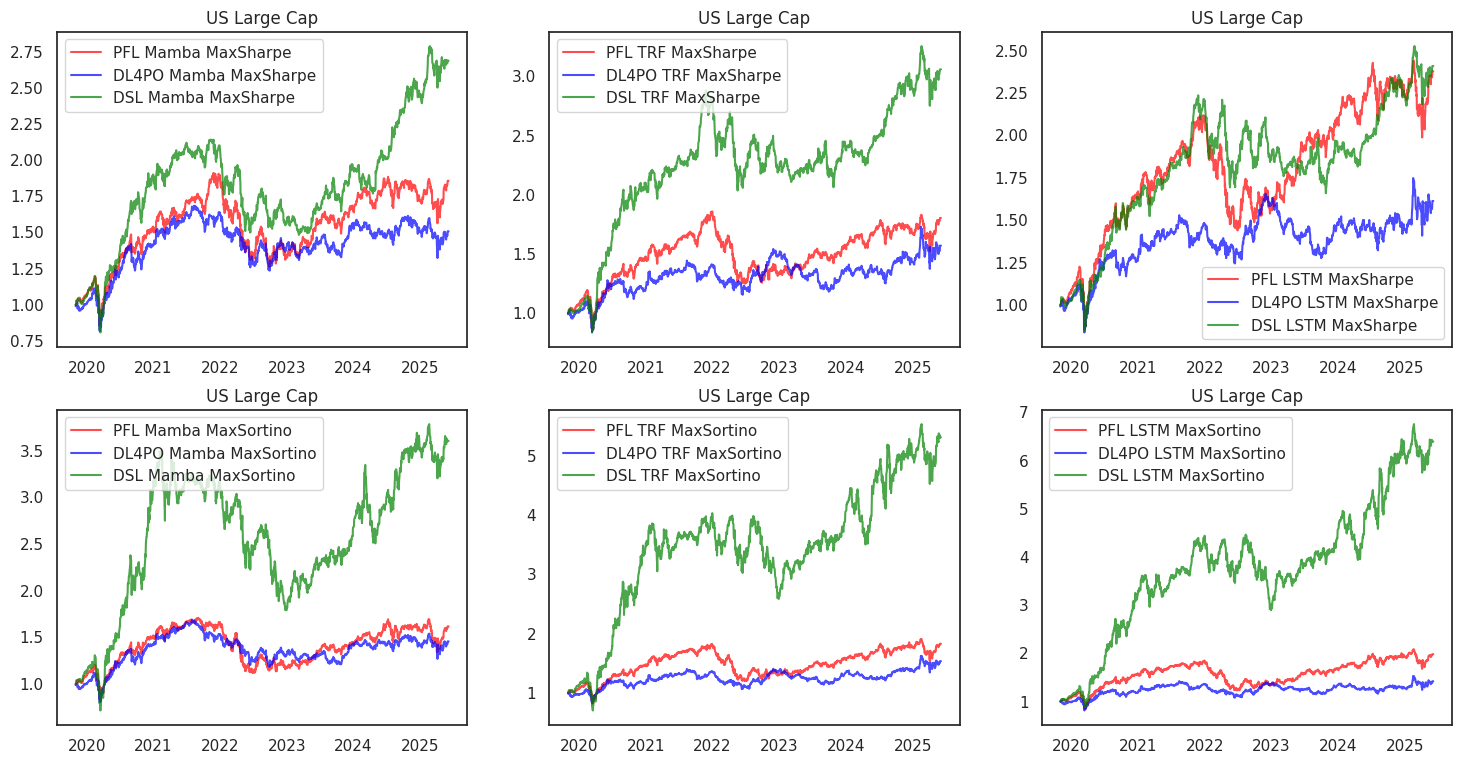

In [59]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe1'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        #ax.plot(universe1_baseline_backtest['equal_weight'].apply(np.exp).cumprod(), color = 'k', label = 'Equal Weight')        

        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('US Large Cap')
        
        ind += 1

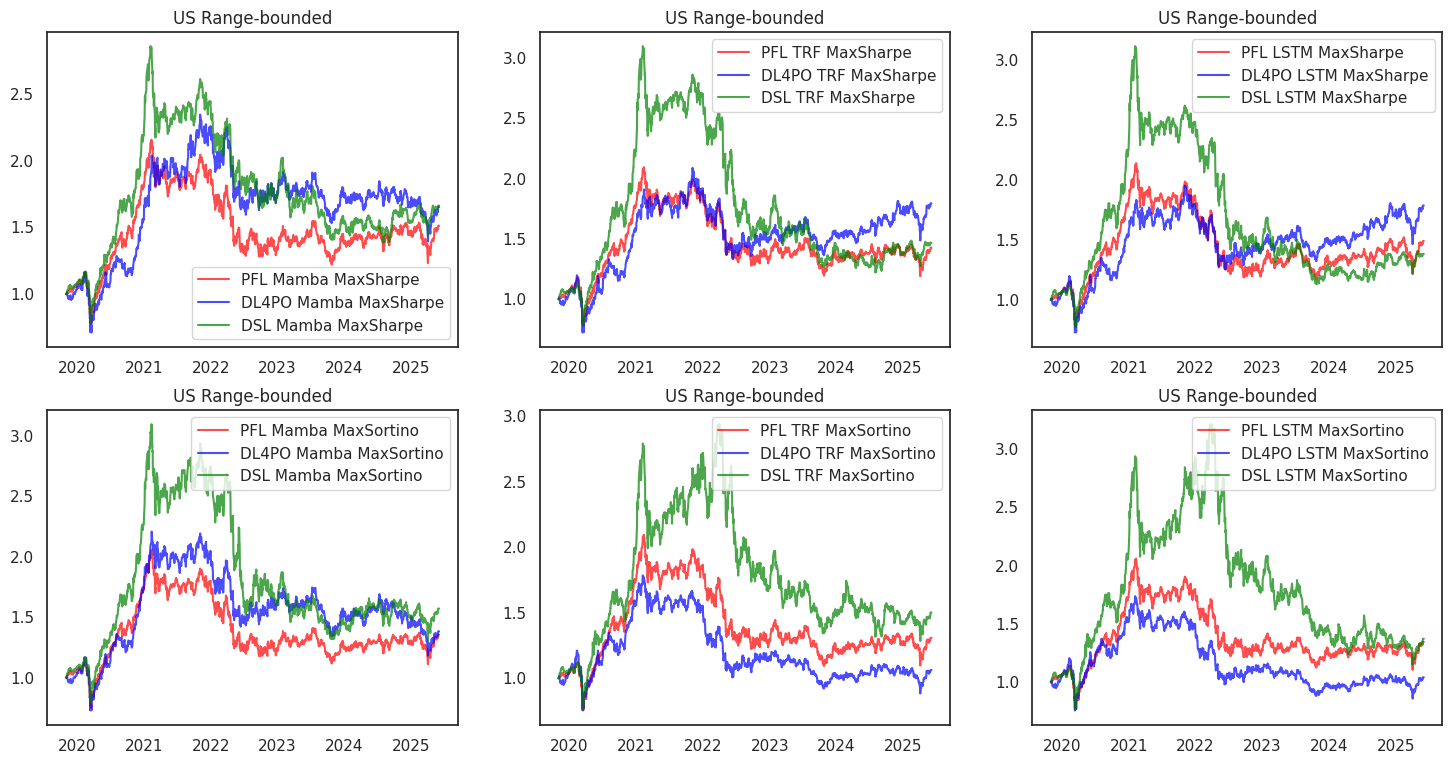

In [60]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe2'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('US Range-bounded')
        
        ind += 1

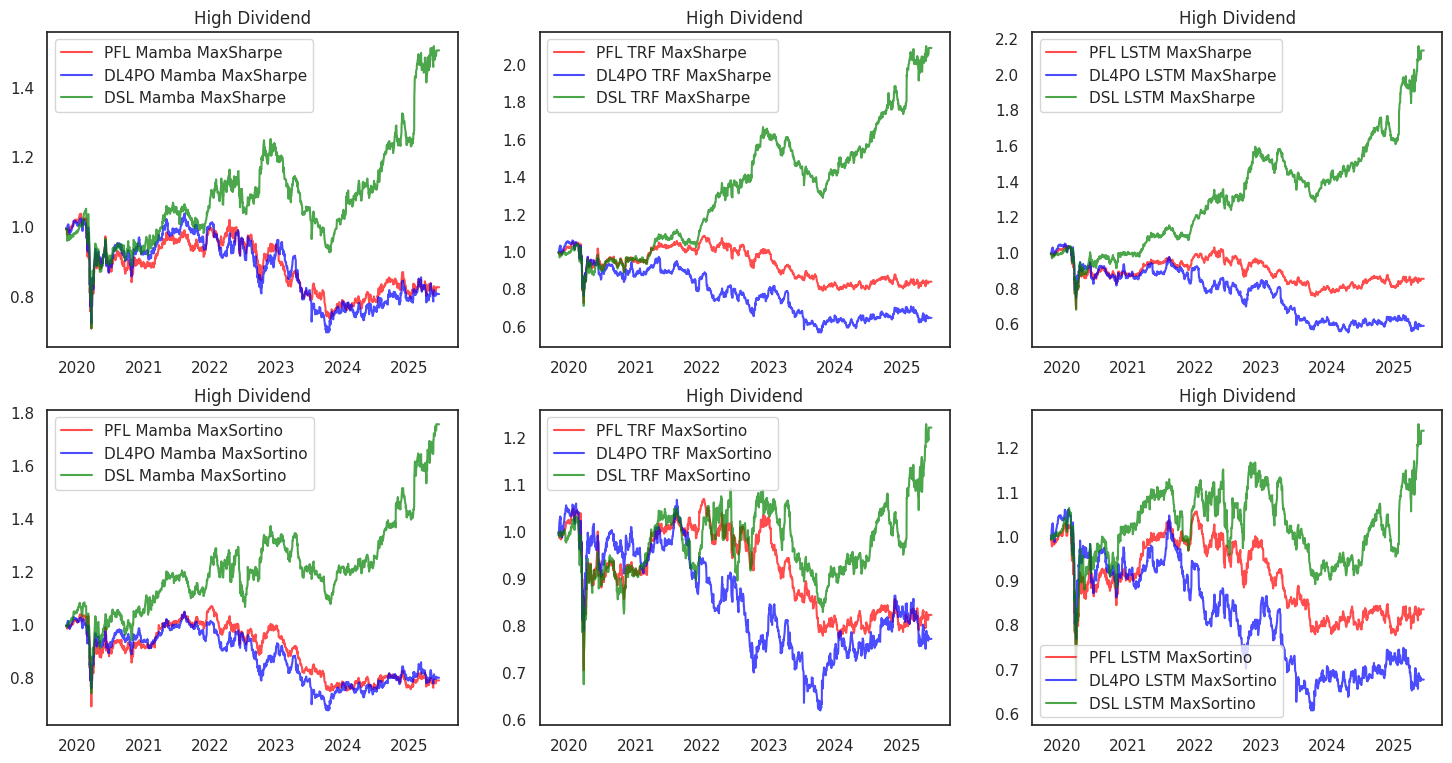

In [61]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe3'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)

        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('High Dividend')
        
        ind += 1

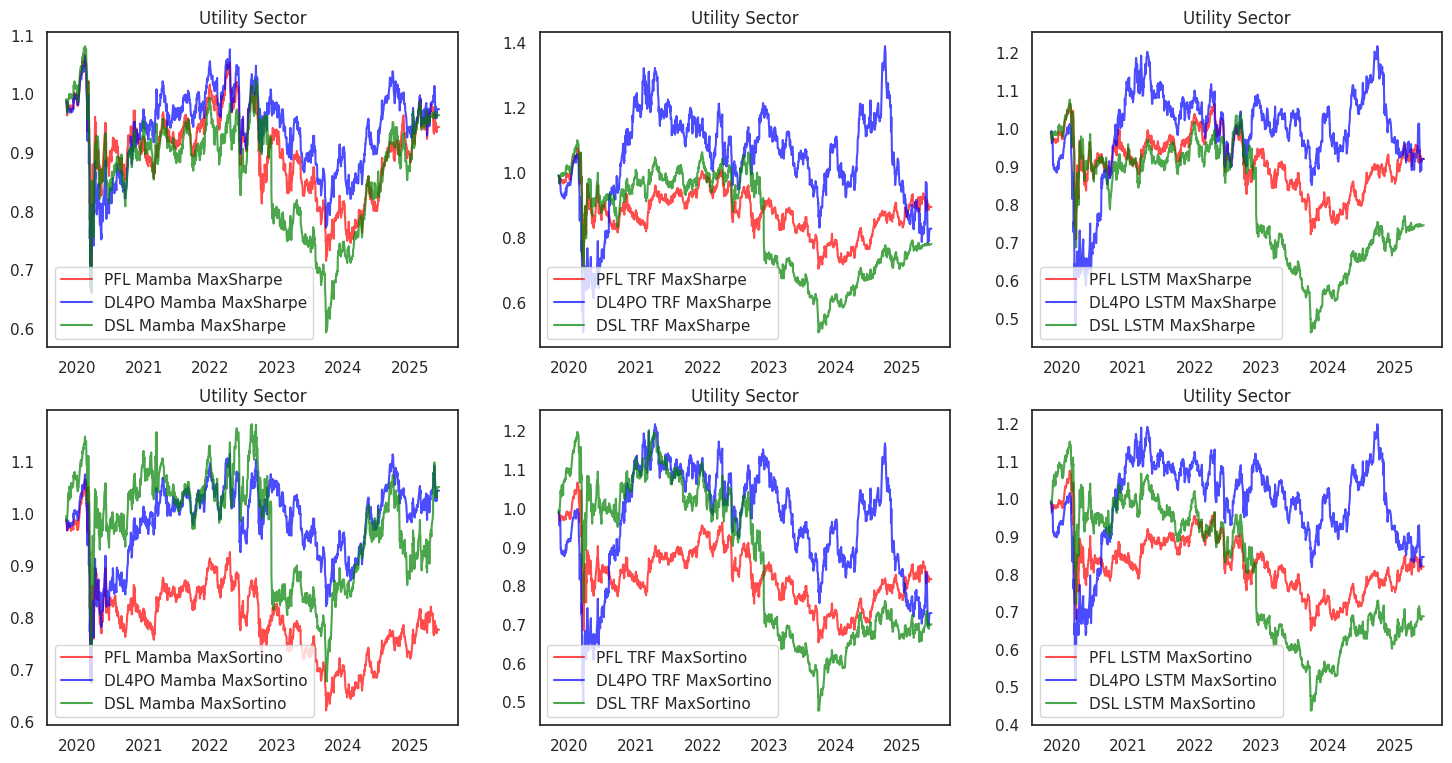

In [62]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe4'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('Utility Sector')
        
        ind += 1

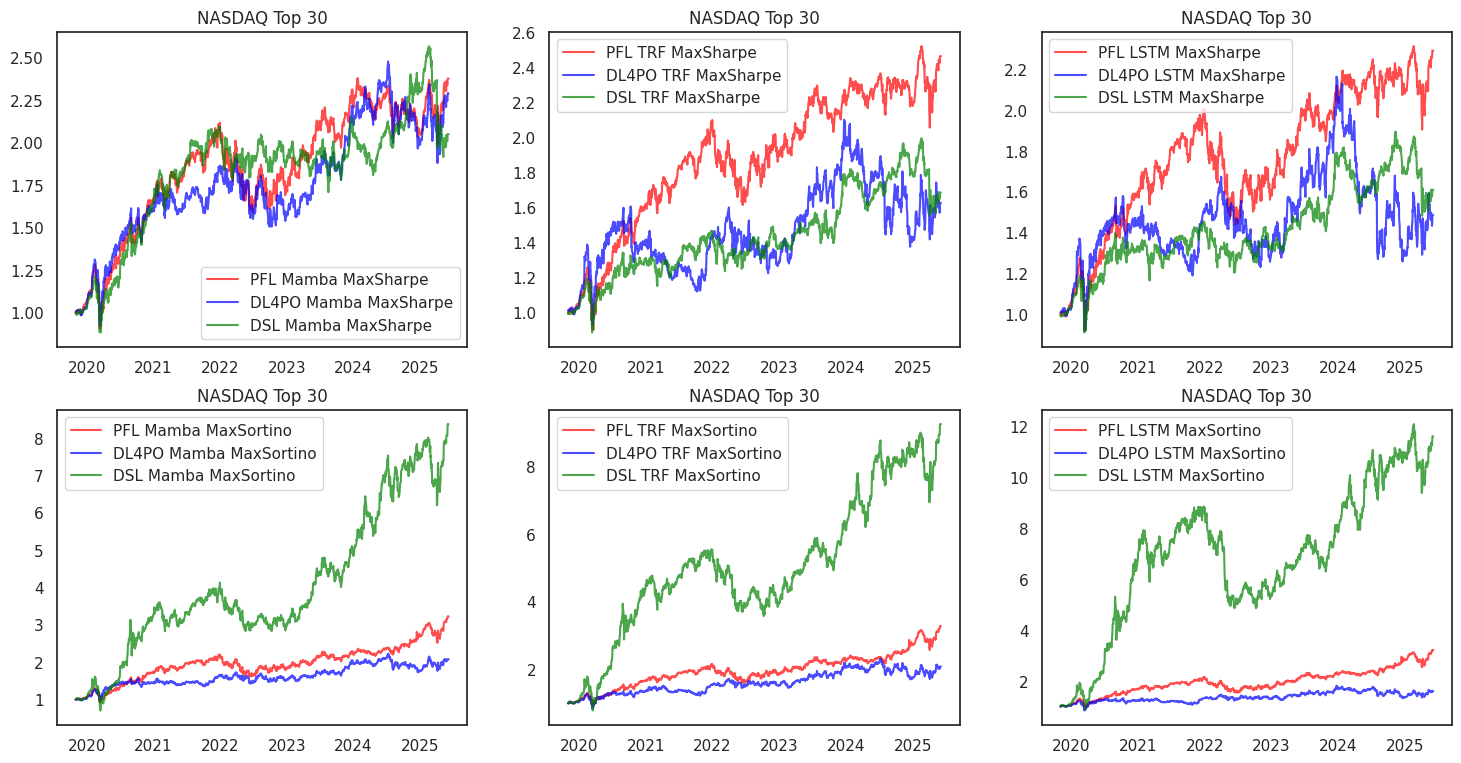

In [63]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe5'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        #ax.plot(universe5_baseline_backtest['equal_weight'].apply(np.exp).cumprod(), color = 'k', label = 'Equal Weight')
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('NASDAQ Top 30')
        
        ind += 1

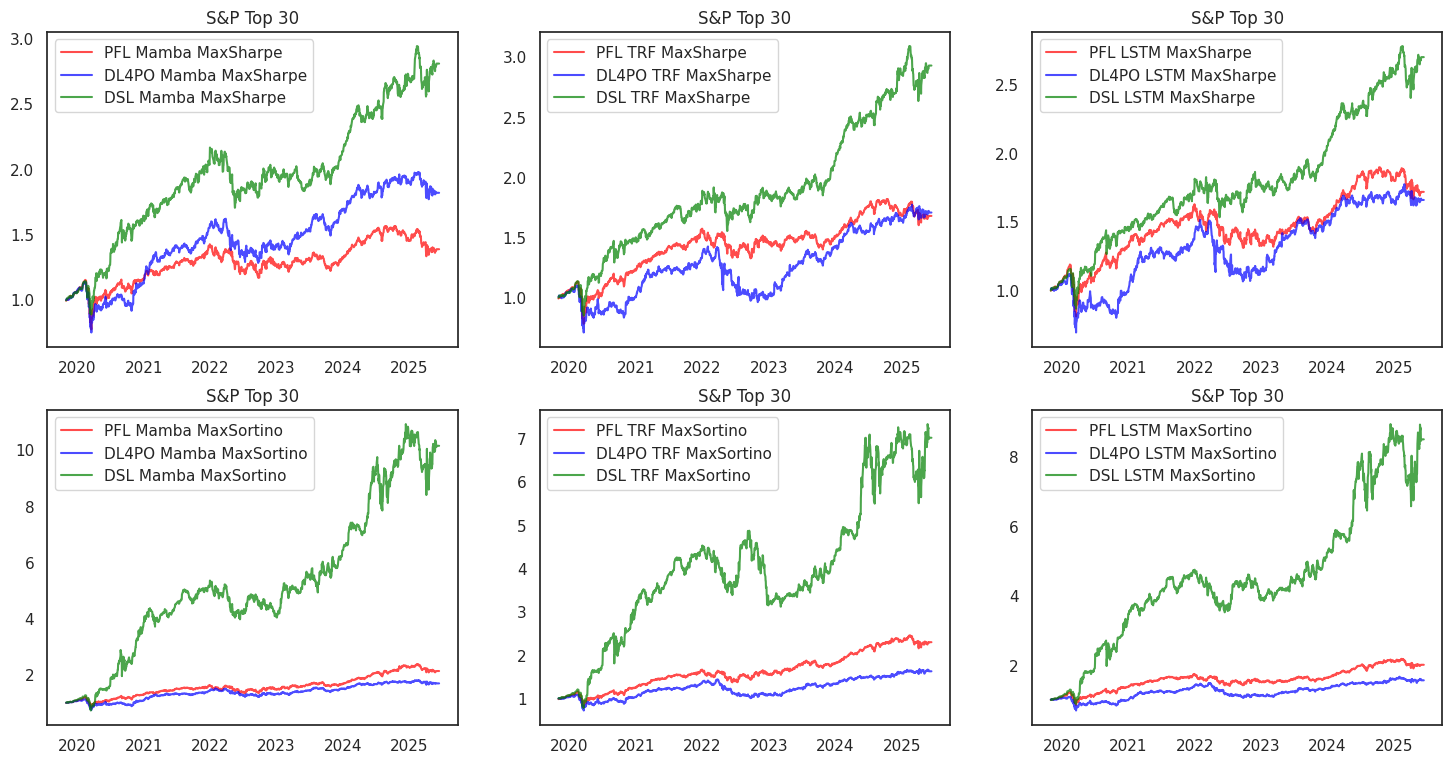

In [64]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe6'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('S&P Top 30')
        
        ind += 1

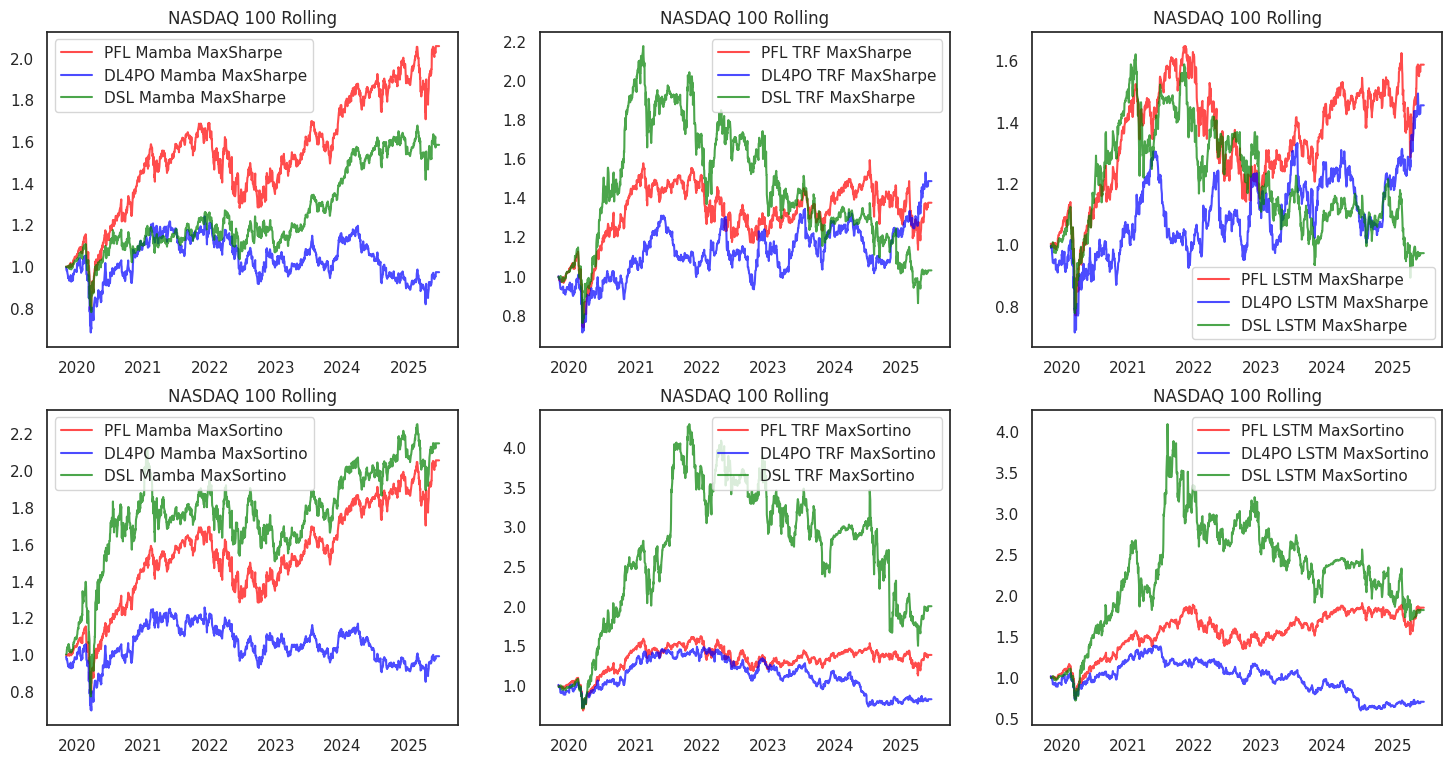

In [65]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe7'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        #ax.plot(universe7_baseline_backtest['equal_weight'].apply(np.exp).cumprod(), color = 'k', label = 'Equal Weight')
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('NASDAQ 100 Rolling')
        
        ind += 1

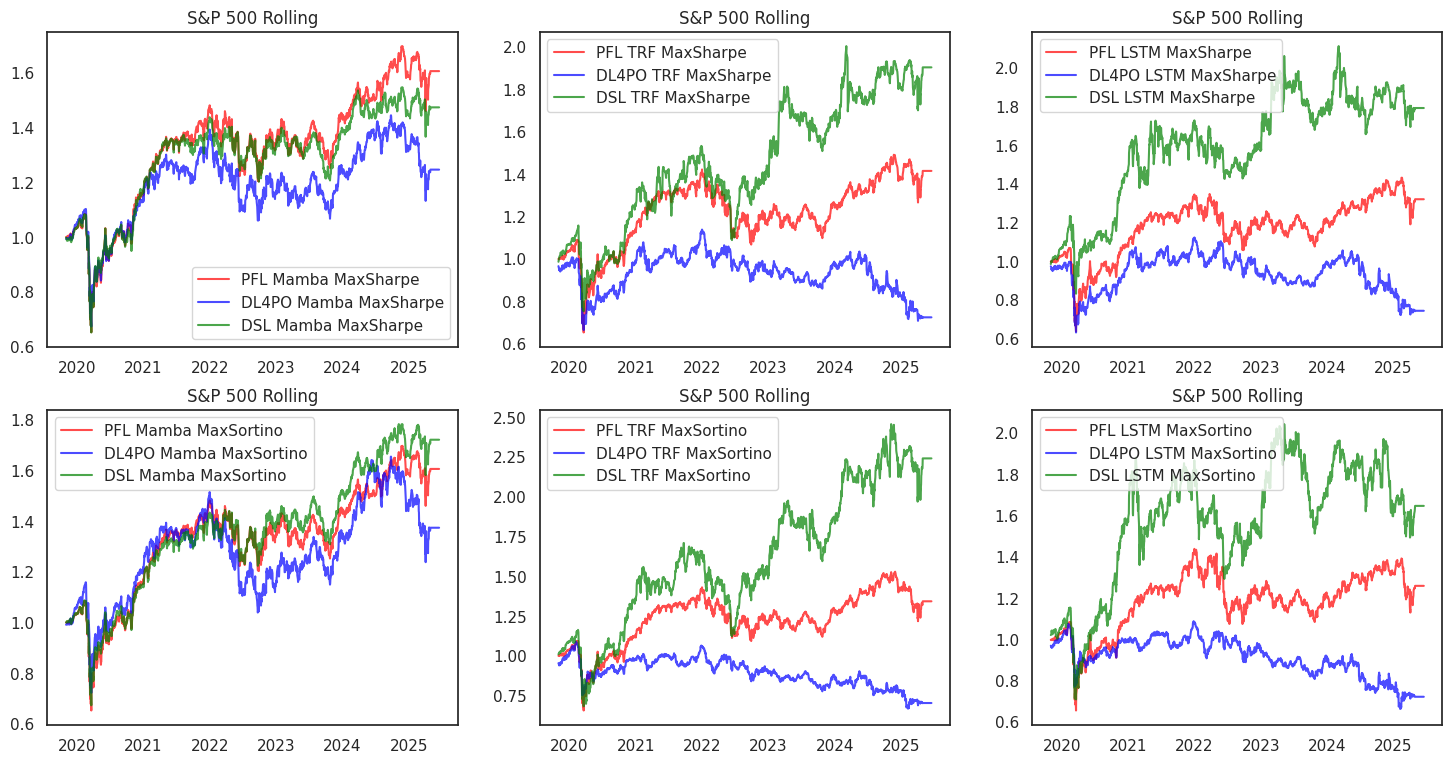

In [66]:
fig = plt.figure(figsize = (18, 9))

ind = 0
universe = 'universe8'
for port in ['MaxSharpe', 'MaxSortino']:
    for model in models:
        ax = plt.subplot(2, 3, ind + 1)
        #ax.plot(universe8_baseline_backtest['equal_weight'].apply(np.exp).cumprod(), color = 'k', label = 'Equal Weight')
        
        object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[0], label = 'PFL ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[1], label = 'DL4PO ' + model + ' ' + port, alpha = alpha)

        object_name = f'{universe.lower()}_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
        ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), '-', color = colors[2], label = 'DSL ' + model + ' ' + port, alpha = alpha)
        
        ax.legend()

        ax.set_title('S&P 500 Rolling')
        
        ind += 1

In [68]:
for universe in universes:
    object_name = f"{universe}_baseline_backtest"
    object = eval(object_name)['equal_weight'].loc[backtest_start:backtest_end]
    print(
        universe + '_equal_weight',
        f'{object.apply(np.exp).prod():.3f}',
        f'{(object.mean() / object.std()) * np.sqrt(252):.3f}',
        f'{(object.mean() / object.clip(upper=0).std()) * np.sqrt(252):.3f}',
    )
    object = eval(object_name)['value_weight'].loc[backtest_start:backtest_end]
    print(
        universe + '_value_weight',
        f'{object.apply(np.exp).prod():.3f}',
        f'{(object.mean() / object.std()) * np.sqrt(252):.3f}',
        f'{(object.mean() / object.clip(upper=0).std()) * np.sqrt(252):.3f}',
    )
    object = eval(object_name)['mSSRM_PGA'].loc[backtest_start:backtest_end]
    print(
        universe + '_mSSRM_PGA',
        f'{object.apply(np.exp).prod():.3f}',
        f'{(object.mean() / object.std()) * np.sqrt(252):.3f}',
        f'{(object.mean() / object.clip(upper=0).std()) * np.sqrt(252):.3f}',
    )
    print()

    for port in ['maxsharpe', 'maxsortino']:
        for model in models:
            object_name = f'{universe.lower()}_PFL_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
            object = eval(object_name).loc[backtest_start:backtest_end]
            print(
                object_name,
                f'{object.apply(np.exp).prod():.3f}',
                f'{(object.mean() / object.std()) * np.sqrt(252):.3f}',
                f'{(object.mean() / object.clip(upper=0).std()) * np.sqrt(252):.3f}',
                f'{object.std():.3f}',
            )
            
            object_name = f'{universe.lower()}_DL4PO_{port.lower()}_{model.lower()}_{optimizer}_{window_size}_backtest'
            object = eval(object_name).loc[backtest_start:backtest_end]
            print(
                object_name,
                f'{object.apply(np.exp).prod():.3f}',
                f'{(object.mean() / object.std()) * np.sqrt(252):.3f}',
                f'{(object.mean() / object.clip(upper=0).std()) * np.sqrt(252):.3f}',
                f'{object.std():.3f}',
            )            

            object_name = f'{universe.lower()}_{port}_{model.lower()}_{optimizer}_{window_size}_backtest'
            object = eval(object_name).loc[backtest_start:backtest_end]
            print(
                object_name,
                f'{object.apply(np.exp).prod().iloc[0]:.3f}',
                f'{(object.mean() / object.std()).iloc[0] * np.sqrt(252):.3f}',
                f'{(object.mean() / object.clip(upper=0).std()).iloc[0] * np.sqrt(252):.3f}',
                f'{object.std().iloc[0]:.3f}',
            )

            print()

universe1_equal_weight 2.791 0.784 1.219
universe1_value_weight 4.610 0.794 1.257
universe1_mSSRM_PGA 2.971 0.768 1.247

universe1_PFL_maxsharpe_mamba_sophia_21_backtest 1.854 0.495 0.766 0.014
universe1_DL4PO_maxsharpe_mamba_sophia_21_backtest 1.505 0.335 0.516 0.014
universe1_maxsharpe_mamba_sophia_21_backtest 2.686 0.783 1.197 0.014

universe1_PFL_maxsharpe_trf_sophia_21_backtest 1.800 0.467 0.710 0.014
universe1_DL4PO_maxsharpe_trf_sophia_21_backtest 1.566 0.363 0.571 0.014
universe1_maxsharpe_trf_sophia_21_backtest 3.056 0.861 1.356 0.014

universe1_PFL_maxsharpe_lstm_sophia_21_backtest 2.374 0.658 1.011 0.015
universe1_DL4PO_maxsharpe_lstm_sophia_21_backtest 1.610 0.383 0.605 0.014
universe1_maxsharpe_lstm_sophia_21_backtest 2.406 0.722 1.114 0.013

universe1_PFL_maxsortino_mamba_sophia_21_backtest 1.613 0.349 0.524 0.015
universe1_DL4PO_maxsortino_mamba_sophia_21_backtest 1.453 0.296 0.453 0.014
universe1_maxsortino_mamba_sophia_21_backtest 3.601 0.681 1.060 0.021

universe1_PFL